# Structural Similarity

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial as spt
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
%matplotlib inline
import itertools
import random
import scikits.statsmodels as sm
import scikits.statsmodels.tools as smtools

ImportError: No module named scikits.statsmodels

In [97]:
events = pd.read_csv('events.csv')
characters = pd.read_csv('characters.csv')

In [98]:
kill_events = events[events['event'] == 'killed']
kill_events = pd.DataFrame(kill_events, index = None, columns=['characterID', 'event', 'withID'])
kill_events = kill_events.dropna()

In [99]:
G = nx.DiGraph()

for row, data in kill_events.iterrows():
    killer = data[2]
    killed = data[0]
    G.add_edge(killer, killed)

In [100]:
ch_team = characters.set_index('characterID')['Team'].to_dict()
for k in ch_team.keys():
    if k not in G.nodes():
        del ch_team[k]

nx.set_node_attributes(G, 'Team', ch_team)
ch_pr = characters.set_index('characterID')['prefix'].to_dict()
for k in ch_pr.keys():
    if k not in G.nodes():
        del ch_pr[k]
nx.set_node_attributes(G, 'prefix', ch_pr)

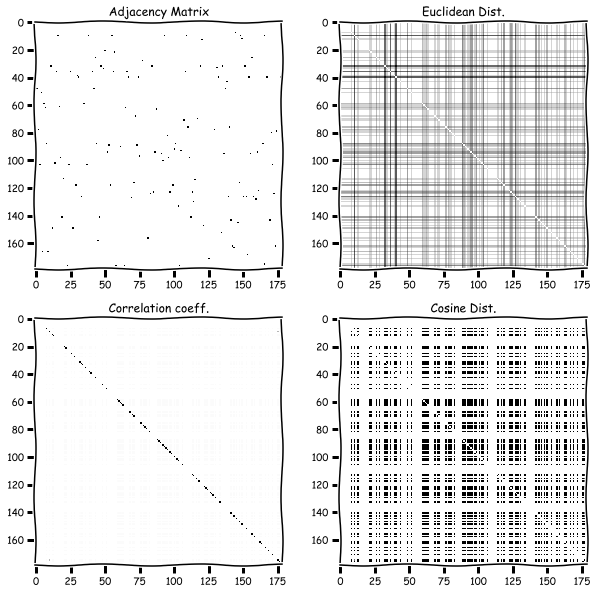

In [101]:
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)
def plotDist(A):
    
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, cmap = 'Greys', interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    
    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 1].set_title('Cosine Dist.')
plotDist(A)

### unfortunetly we can not use node reordening to make this graphs more clear as it was done. From visualisation of this metrics i cannot make any conclusion, so i need another metric that will somehow measure the similarity let's take Jaccard similarity metric as it can be used for digraph.

In [102]:
def simrank(G, r=0.8, max_iter=100, eps=1e-4):

    nodes = G.nodes()
    nodes_i = {k: v for(k, v) in [(nodes[i], i) for i in range(0, len(nodes))]}

    sim_prev = np.zeros(len(nodes))
    sim = np.identity(len(nodes))

    for i in range(max_iter):
        if np.allclose(sim, sim_prev, atol=eps):
            break
        sim_prev = np.copy(sim)
        for u, v in itertools.product(nodes, nodes):
            if u is v:
                continue
            u_ns, v_ns = G.predecessors(u), G.predecessors(v)

            # evaluating the similarity of current iteration nodes pair
            if len(u_ns) == 0 or len(v_ns) == 0: 
                # if a node has no predecessors then setting similarity to zero
                sim[nodes_i[u]][nodes_i[v]] = 0
            else:                    
                s_uv = sum([sim_prev[nodes_i[u_n]][nodes_i[v_n]] for u_n, v_n in itertools.product(u_ns, v_ns)])
                sim[nodes_i[u]][nodes_i[v]] = (r * s_uv) / (len(u_ns) * len(v_ns))


    return sim

In [103]:
l=list()
MA=simrank(G)
for i in range(178):
    for j in range(178) :
        if (MA[i][j]>=0.5)&(i!=j)&([i,j] not in l)&([j,i] not in l):
            l.append([i,int(j)])

In [104]:
nodes_list=list()
for i in l:
    nodes_list.append([G.nodes()[i[0]],G.nodes()[i[1]]])

## there you can see pair of similar nodes with metric value>=0.5. This metrics can be calculated for di graph but it can not use the information of directed edges so it only shows the persons who interact with the same person in terms of killing but not in terms killed or was killed by. So it is also bad metric for digraph. 

In [105]:
similar_char=list()
for n in nodes_list:
    similar_char.append([characters[characters['characterID'] == n[0]]['Name'].to_dict().values()[0],characters[characters['characterID'] == n[1]]['Name'].to_dict().values()[0]])
similar_char    

[['Iggo', 'Tickler'],
 ['Iggo', 'Dareon'],
 ['Kerwin', 'Talbert Serry'],
 ['Aegon Frey (Jinglebell)', 'Stevron Frey'],
 ['Aegon Frey (Jinglebell)', 'Merrett Frey'],
 ['Aegon Frey (Jinglebell)', 'Ryman Frey'],
 ['Senelle', 'Falyse Stokeworth'],
 ['Khrazz', 'Mero'],
 ['Shae', 'Tywin Lannister'],
 ['Shagwell', 'Timeon'],
 ['Shagwell', 'Pyg'],
 ['Shagwell', 'Rorge'],
 ['Cressen', 'Guncer Sunglass'],
 ['Cressen', 'Hubard Rambton'],
 ['Cressen', 'Cortnay Penrose'],
 ['Cressen', 'Renly Baratheon'],
 ['Cressen', 'Alester Florent'],
 ['Mag Mar Tun Doh Weg', 'Styr'],
 ['Alebelly', 'Stiv'],
 ['Alebelly', 'Mikken'],
 ['Alebelly', 'Ralf Kenning'],
 ['Alebelly', 'Benfred Tallhart'],
 ['Alebelly', 'Chayle'],
 ['Softfoot', 'Thistle'],
 ['Softfoot', 'Hake'],
 ['Softfoot', 'Waymar Royce'],
 ['Softfoot', 'Chett'],
 ['Softfoot', 'Lark'],
 ['Pate', 'Weese'],
 ['Pate', 'Chiswyck'],
 ['Stafford Lannister', 'Tion Frey'],
 ['Stafford Lannister', 'Willem Lannister'],
 ['Alfyn', 'Varly'],
 ['Garse Goodbrook', 'M

Assorativity for different attributes. 

In [106]:
nx.assortativity.attribute_assortativity_coefficient(G, 'Team')
as_dict = nx.assortativity.attribute_mixing_dict(G, 'Team')
as_dict

{'Bolton (Lannister)': {},
 'Bolton (North)': {'Bolton (Lannister)': 1,
  'Greyjoy': 1,
  'Stark': 3,
  'none': 1},
 'Brave Companions': {'Lannister': 2, 'none': 1},
 'Citadel': {},
 'Drogo': {'Drogo': 1, 'Targaryen': 1},
 'Essos': {'Targaryen': 2},
 'Faceless Men': {'Citadel': 1, 'Lannister': 2},
 'Frey (Lannister)': {},
 'Frey (North)': {'Stark': 3},
 'Greyjoy': {'Greyjoy': 4,
  'Stark': 4,
  'Tyrell': 1,
  'Wildlings (north of wall)': 1},
 'Lannister': {'Frey (Lannister)': 2,
  'Lannister': 1,
  'Robert': 2,
  'Stark': 4,
  'none': 1},
 'Littlefinger': {'Littlefinger': 1, 'Robert': 1},
 'Martell': {'Robert': 1},
 'Night Watch': {'Night Watch': 4,
  'Tyrell': 1,
  'Wildlings (north of wall)': 5},
 'Red God': {'Renly': 2, 'Stannis': 4},
 'Renly': {'Brave Companions': 3, 'Stark': 1, 'none': 1},
 'Robert': {'Brave Companions': 2,
  'Essos': 1,
  'Martell': 1,
  'Robert': 5,
  'Second Sons': 1,
  'Stark': 4},
 'Second Sons': {},
 'Stannis': {},
 'Stark': {'Bolton (Lannister)': 1,
  'Brav

In [107]:
nx.assortativity.attribute_assortativity_coefficient(G, 'prefix')
as_dict = nx.assortativity.attribute_mixing_dict(G, 'prefix')
as_dict

{nan: {nan: 53,
  'King ': 1,
  'Lady ': 1,
  'Lord ': 8,
  'Lord Commander ': 1,
  'Maester ': 2,
  'Septon ': 1,
  'Ser ': 10},
 'Captain ': {nan: 2},
 'Grand Maester ': {},
 'Khal ': {nan: 1},
 'King ': {},
 'Lady ': {nan: 10, 'Khal ': 1, 'Prince ': 1, 'Ser ': 2},
 'Lord': {nan: 1, 'Ser ': 1},
 'Lord ': {nan: 7, 'Grand Maester ': 1, 'Lady ': 1, 'Septon ': 1, 'Ser ': 3},
 'Lord Commander ': {},
 'Maester ': {nan: 2},
 'Prince ': {},
 'Septon ': {},
 'Ser ': {nan: 16, 'Lady ': 1, 'Lord ': 2, 'Prince ': 1}}

# 2.Find the example of temporal network, that increases assortativity at early stages and became higly disassortative later. Explain this process.

I cannot find the example clearly in the internet so i thought a little about what it can be. It can be network of development of mankind. On the first stage there was a lot of tribes and it was like many not connected subgraphs with edges this person knows this person and each subgraph was full graph because in tribes at first everyone know everyone. Than tribes growed and liders of tribes start to comunicate more over the persons from other tribes (not liders) started to recognize the liders of another tribes so even on this stage the starts incriease of dissartotivity as nodes with big degree is known by nodes with degree less than this node. 

# 3.Take biological network. Let's prun the largest-degree nodes of a growing scale-free network has the effect of decreasing the degree correlation coefficient (assortativity) in a stable way, while keeping both the trait of a power-law degree distribution and the main properties of network's robustness. Explain the results. Propose a generative model for disassortative growing scale-free networks.

## Let's remind formula of assortativity due to nodes degree $r=\frac{S_e*S_1-S_2^2}{S_3*S_1-S_2^2}$ where $s_1=\sum{k_i}$ $s_2=\sum{k_i^2}$ $s_3=\sum{k_i^3}$ $s_e=\sum A_{ij}*ki*kj$
as we remove nodes with highes degrees so the value of s_3 decreases so for decrease of assort_coef $S_e$ should decrease even more than $S_3$ Is it possible? Yes it's for example we removed the most one big node that made another big nodes disconected. Now in networkx we have model that generate scale_free_graph let's play with parameters and get our graph. where parameters are:

alpha (float) – Probability for adding a new node connected to an existing node chosen randomly according to the in-degree distribution.

beta (float) – Probability for adding an edge between two existing nodes. One existing node is chosen randomly according the in-degree distribution and the other chosen randomly according to the out-degree distribution.

gamma (float) – Probability for adding a new node conecgted to an existing node chosen randomly according to the out-degree distribution.

In [144]:
G1 = nx.scale_free_graph(100,0.05,0.9,0.05)
nx.degree_assortativity_coefficient(G1)

-0.0036204598616494119

another idea is to generate graph and on different levels connect build different amount of edges (alternate big amount of edges with small on each step) and only connect nodes with nodes from level +1 or -1 so the nodes of the same level is not connected this will help do get low assortativity. And on each step derease the average amount of edges that we add. Not sure if it will be scale free. 